In [3]:
import pydicom
from itertools import chain
import os
import numpy
from matplotlib import pyplot, cm
import cv2
import pandas as pd
from keras.utils import to_categorical, Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


## 1 - Creation of Datasets and Dataframe and Image Enhancement

First we want to convert all the dicom images from  to JPEG images, and put them in a single folder, corresponding to training or testing set.
We will also apply Constrast Limited Adaptative Histogram Equalization (CLAHE) to each image, w.r.t their size, as mentionned in this article : [agab DA, Sharkas M, Marshall S, Ren J. 2019. Breast cancer detection using deep convolutional neural networksand support vector machines](http://doi.org/10.7717/peerj.6201)

In [12]:
# Look for all cropped images given from dataframes "paths_dicom_df" in the folder "pth_folder_dicom", 
# apply CLAHE algorithm if wanted, and record new JPEG images in "path_jpg"
# Also creates and record the data frame necessary for the Keras image generator
def dicom_to_jpg_with_df(paths_dicom_df, pth_folder_dicom, path_jpg, ENHANCE=True):
    clahe1 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6,6)) #CLAHE for local contrast enhancing
    clahe2 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe3 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10,10))
    threshold1 = 250*250
    threshold2 = 400*400
    i=0
    dict_for_df = {'filename':[], 'pathology':[]}
    for df_path in paths_dicom_df:
        #df = pd.read_csv(df_path, sep=',', header=0, engine='python', quotechar='"')
        df = pd.read_csv(df_path, sep=';', header=0)
        df.dropna(0, inplace=True, how='all') # Remove fully empty rows
        df.reset_index(drop=True, inplace=True)
        for index, row in df.iterrows():
            foldername = row["cropped image file path"]
            arg_list = foldername.split('/')
            path = os.path.join(pth_folder_dicom, arg_list[0])
            dict_for_df['filename'].append(arg_list[0]+'.jpg')
            dict_for_df['pathology'].append(row.pathology)
            for dirName, subdirList, fileList in os.walk(path):
                for filename in fileList:
                    filepath = os.path.join(dirName, filename)
                    dic = pydicom.read_file(filepath)
                    if (dic.SeriesDescription == "cropped images"):  # check whether the file's segmented image
                        pixels = dic.pixel_array
                        size = pixels.size
                        if ENHANCE:
                            if size<threshold1:
                                pixels = clahe1.apply(pixels) 
                            elif size<threshold2:
                                pixels = clahe2.apply(pixels)
                            else:
                                pixels = clahe3.apply(pixels)
                        cv2.imwrite(os.path.join(path_jpg, arg_list[0])+".jpg", pixels/255., [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                        i+=1
    df_returned = pd.DataFrame(data=dict_for_df)
    df_returned.pathology[df_returned.pathology == 'BENIGN_WITHOUT_CALLBACK'] = 'BENIGN'
    return df_returned
    

Don't forget to change paths according to your computer. Execute the commented lines to extract data.

In [2]:
path_train_mass_df = "D:\\datas\\Mammographies\\mass_case_description_train_set.csv"
path_train_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"
path_test_mass_df = "D:\\datas\\Mammographies\\mass_case_description_test_set.csv"
path_test_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"

path_dicom_folder = "D:\\datas\Mammographies\\CBIS-DDSM"

path_train_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_train\\"
path_test_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_test\\"

#df_test = dicom_to_jpg_with_df([path_test_mass_df, path_test_calc_df], path_dicom_folder, path_test_crop_jpg)
#df_test.to_csv("test_labels.csv", index=False)
#
#df_train = dicom_to_jpg_with_df([path_train_mass_df, path_train_calc_df], path_dicom_folder, path_train_crop_jpg)
#df_train.to_csv("train_labels.csv", index=False)

In [1]:
path_train_mass_df = "C:\\Users\\Utilisateur\\Documents\\Stage2A\\CBIS-DDSM\\mass_case_description_train_set.csv"
path_train_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"
path_test_mass_df = "C:\\Users\\Utilisateur\\Documents\\Stage2A\\CBIS-DDSM\\mass_case_description_test_set.csv"
path_test_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"

path_dicom_folder = "C:\\Users\\Utilisateur\\Documents\\Stage2A\\CBIS-DDSM\\all_cases\\"

path_train_crop_jpg = "C:\\Users\\Utilisateur\\Documents\\Stage2A\\CBIS-DDSM\\train_crop_mass_jpg\\"
path_test_crop_jpg = "C:\\Users\\Utilisateur\\Documents\\Stage2A\\CBIS-DDSM\\test_crop_mass_jpg\\"

#df_test = dicom_to_jpg_with_df([path_test_mass_df], path_dicom_folder, path_test_crop_jpg)
#df_test.to_csv("test_labels.csv", index=False)
#
#df_train = dicom_to_jpg_with_df([path_train_mass_df], path_dicom_folder, path_train_crop_jpg)
#df_train.to_csv("train_labels.csv", index=False)

## 2- Feature extraction

Given a certain model (e.g. the convolutionnal basse of VGG16 network), we simply passes the data in the input of the model and get the features. This is done using the method *flow_from_dataframe* to avoid loading the whole data in memory.

In [7]:
df_train = pd.read_csv("train_labels.csv", sep=',', header=0)
df_test = pd.read_csv("test_labels.csv", sep=',', header=0)

In [11]:
#Extract features from data contained in dictory. Data passes by batches in the model chosen.
#Returns the features extracted through the model in  single array
def extract_features(dataframe, directory, sample_count, subset):
    # Preprocess data
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe, 
        directory=directory, 
        x_col="filename", y_col="pathology", class_mode="categorical",
        target_size=(224,224), 
        batch_size=batch_size, shuffle=True, 
        interpolation="bilinear",
        subset=subset)
    print(generator.class_indices)
    # Pass data through convolutional base
    i = 0
    inputs_batch, labels = next(generator)
    features = conv_base.predict(inputs_batch)
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features = numpy.concatenate((features, features_batch), axis=0)
        labels = numpy.concatenate((labels, labels_batch), axis=0)
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

# Computes the total number of samples used, given validation_ratio and augmentation factor.
def compute_num_samples(data_size, validation_ratio, aug_factor):
    train_size = int((1-validation_ratio) * data_size * aug_factor)
    return train_size

In [45]:
valid_ratio = 0.3 # Validation ratio
batch_size = 32
augmentation = 3 # Augmentation ratio
data_size = df_train.shape[0]
train_size = compute_num_samples(data_size, valid_ratio, augmentation) #Get number of amples for training
valid_size = compute_num_samples(data_size, 1-valid_ratio, augmentation) #Get number of sample for validation
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Get convolutionnal base of VGG16

datagen = ImageDataGenerator(
         rescale=1/255.,
         vertical_flip=True,
         horizontal_flip=True, 
         validation_split=valid_ratio)

train_features, train_labels = extract_features(df_train, path_train_crop_jpg, train_size, "training")
validation_features, validation_labels = extract_features(df_train, path_train_crop_jpg, valid_size, "validation") 

1318


## 3 - Classifiers

We will now try different classifiers to interpet the features exctracted.

### 3.1 - Fully Connected Layers

In [ ]:
epochs = 50
batch_size = 32
model_fc = models.Sequential()
model_fc.add(layers.Flatten(input_shape=(7,7,512)))
model_fc.add(layers.Dense(512, activation='relu', input_dim=(7*7*512)))
model_fc.add(layers.Dense(512, activation='relu'))
model_fc.add(layers.Dropout(0.5))
model_fc.add(layers.Dense(2, activation='sigmoid'))
model_fc.summary()

# Compile model
model_fc.compile(optimizer=optimizers.Adamax(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history_fc = model_fc.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

We now plot the accuracy and the loss for both sets

In [18]:
# Plot results
import matplotlib.pyplot as plt

def plot_history(h, title_acc=None, title_loss=None):
    acc = history_ft.history['acc']
    val_acc = history_ft.history['val_acc']
    loss = history_ft.history['loss']
    val_loss = history_ft.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    if title_acc!=None:
        plt.savefig('{}.png'.format(title_acc))

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    
    plt.title('Training and validation loss')
    plt.legend()
    if title_acc!=None:
        plt.savefig('{}.png'.format(title_loss))

    plt.show()

In [ ]:
plot_history(history_fc, "example_validation", "exemple_loss")

### 3.2 - Global Average Pooling

In [ ]:
### Define model
epochs = 120

model_gap = models.Sequential()
model_gap.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model_gap.add(layers.Dense(2, activation='sigmoid'))
model_gap.summary()

# Compile model
model_gap.compile(optimizer=optimizers.Adamax(lr = 0.05),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history_gap = model_gap.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

In [ ]:
plot_history(history_gap, "gap_validation", "gap_loss")

### 3.3 Linear SVM Classifier

Here we try SVM directly on features extracted with the convolutionnal part. The dimensions of features output is huge, thus the SVM converges very slowly.
We concatenate training and validation features because we will use k-fold validation with 10 groups.

In [ ]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [ ]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

scaler = StandardScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=2000, dual="False")  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

In [ ]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))

## 4. Model Fine Tuning

We unfreeze some convolutionnal layers.
First we train only the classifier, then keep the classifier weights, unfreeze last convolutionnal layers, and retrain our model.

In [9]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(224, 224, 3)))
 
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(512, activation="relu")(headModel)
headModel = layers.Dense(512, activation="relu")(headModel)
headModel = layers.Dropout(0.2)(headModel)
headModel = layers.Dense(2, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_ft = Model(inputs=baseModel.input, outputs=headModel)

for layer in model_ft.layers[:19]:

# loop over the layers in the model and show which ones are trainable
# or not	layer.trainable = False

for layer in model_ft.layers:
	print("{}: {}".format(layer, layer.trainable))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<keras.engine.input_layer.InputLayer object at 0x0000029E4D194BE0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53038BE0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53038A20>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E53048CF8>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530485C0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53094EF0>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E530B7C88>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530B7F28>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530CAC18>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E5310E7B8>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E53129D68>: False
<keras.layers.convo

In [15]:
#Execute this cell to freeze or unfreeze layers
for layer in model_ft.layers[:15]:
	layer.trainable = False
    
for layer in model_ft.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x0000029E4D194BE0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53038BE0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53038A20>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E53048CF8>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530485C0>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53094EF0>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E530B7C88>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530B7F28>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E530CAC18>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E5310E7B8>: False
<keras.layers.pooling.MaxPooling2D object at 0x0000029E53129D68>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E53129CF8>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E5315B668>: False
<keras.layers.convolutional.Conv2D object at 0x0000029E5319043

In [16]:
valid_ratio = 0.3
batch_size = 32
augmentation = 3
data_size = df_train.shape[0]
print(df_train.shape[0])
train_size = compute_num_samples(data_size, valid_ratio, augmentation)
valid_size = compute_num_samples(data_size, 1-valid_ratio, augmentation)

datagen = ImageDataGenerator(
         rescale=1/255.,
         vertical_flip=True,
         horizontal_flip=True, 
         validation_split=valid_ratio)

# Preprocess data
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=path_train_crop_jpg, 
    x_col="filename", y_col="pathology", class_mode="categorical",
    target_size=(224,224), 
    batch_size=batch_size, shuffle=True, 
    interpolation="bilinear",
    subset="training")

valid_generator = datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=path_train_crop_jpg, 
    x_col="filename", y_col="pathology", class_mode="categorical",
    target_size=(224,224), 
    batch_size=batch_size, shuffle=True, 
    interpolation="bilinear",
    subset="validation")

model_ft.compile(optimizer=optimizers.Adamax(0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history_ft = model_ft.fit_generator(
        train_generator,
        epochs=10,
        steps_per_epoch = train_size/batch_size,
        validation_data=valid_generator,
        validation_steps = valid_size/batch_size)

1318
Found 923 images belonging to 2 classes.
Found 395 images belonging to 2 classes.
Epoch 1/10
87/86 [==============================] - 253s 3s/step - loss: 0.6433 - acc: 0.6497 - val_loss: 0.6187 - val_acc: 0.6840
Epoch 2/10
87/86 [==============================] - 120s 1s/step - loss: 0.5222 - acc: 0.7465 - val_loss: 0.5472 - val_acc: 0.7476
Epoch 3/10
87/86 [==============================] - 120s 1s/step - loss: 0.4539 - acc: 0.7926 - val_loss: 0.5482 - val_acc: 0.7446
Epoch 4/10
87/86 [==============================] - 120s 1s/step - loss: 0.4353 - acc: 0.7976 - val_loss: 0.5870 - val_acc: 0.7450
Epoch 5/10
87/86 [==============================] - 120s 1s/step - loss: 0.4103 - acc: 0.8158 - val_loss: 0.5839 - val_acc: 0.7454
Epoch 6/10
87/86 [==============================] - 121s 1s/step - loss: 0.3666 - acc: 0.8456 - val_loss: 0.5825 - val_acc: 0.7389
Epoch 7/10
87/86 [==============================] - 120s 1s/step - loss: 0.3536 - acc: 0.8548 - val_loss: 0.6434 - val_acc: 0.7

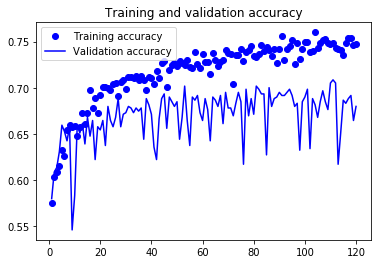

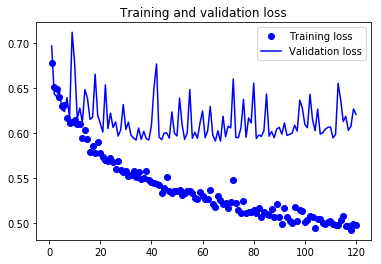

In [34]:
plot_history(history_ft, "gap_validation", "gap_loss")

## 5 - SVM Classifying on reduced number of features

We pass the validation data through Neural Network, then we train the SVM with this data. We only classifiy the two features extracted by the previous DCNN. We should consider several kernel for the SVM, as linear one or Medium Gaussian one.

### 5.1 Training of the svm

Exec the following cell if you use only convolutionnal base (see part 2) to extract features. Otherwise re-generate network output with
next cell

In [87]:
# Exec this code if you use only convolutionnal base (see part 2) to extract features. Otherwise re-generate network output with
# next cell
svm_features = numpy.concatenate((train_features, validation_features))
svm_labels = numpy.concatenate((train_labels, validation_labels))[:,0]
net_output = model_fc.predict(validation_features)
svm_labels = validation_labels[:,0] # Create a 1D vector of labels
svm_labels = svm_labels.astype(int)
svm_labels

array([1, 1, 1, ..., 1, 1, 0])

In [13]:
i = 0
inputs_batch, labels = next(valid_generator)
features = model_ft.predict(inputs_batch)
for inputs_batch, labels_batch in valid_generator:
        features_batch = model_ft.predict(inputs_batch)
        features = numpy.concatenate((features, features_batch), axis=0)
        labels = numpy.concatenate((labels, labels_batch), axis=0)
        i+=1
        if i*32>395*4:
            break

In [ ]:
# Re-formate labels as 1D array
svm_labels = validation_labels[:,0]
svm_labels = svm_labels.astype(int)
svm_labels

We train the model and evaualte it with k-fold validation

In [ ]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X_train2, y_train = features.copy(), labels[:,0]

scaler = StandardScaler(copy=False)
scaler.fit(X_train2)
X_train2 = scaler.transform(X_train2)

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=2000, dual="False")  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
print(y_train.shape)
clf.fit(X_train2, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(numpy.mean(cross_val_score(clf, X_train2, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(numpy.std(cross_val_score(clf, X_train2, y_train, cv=10)))

### 5.2 Test of the classifier on test data

We can choose to use the SVM or not, depending on the function we choose.

In [18]:
from keras.preprocessing import image
def compute_predicitons(classifier, path_test_jpg, df_test_labels):
    n_img = df_test_labels.shape[0]
    c_fp = 0.
    c_fn = 0.
    c_tp = 0.
    c_tn = 0.
    for index, row in df_test_labels.iterrows():
        img_path = os.path.join(path_test_jpg, row.filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        prediction = classifier.predict(img_tensor.reshape(1,224, 224, 3))
        if prediction[0,1] < 0.5:
            if row.pathology == "BENIGN":
                c_tn += 1
            else:
                c_fn += 1
        else:
            if row.pathology == "BENIGN":
                c_fp += 1
            else:
                c_tp += 1
    return (c_tp+c_tn)/n_img, c_tp/(c_tp+c_fn), c_tn/(c_tn+c_fp), c_tp/(c_tp+c_fp)  

In [17]:
from keras.preprocessing import image
def compute_predicitons_with_svm(classifier, path_test_jpg, df_test_labels):
    n_img = df_test_labels.shape[0]
    c_fp = 0.
    c_fn = 0.
    c_tp = 0.
    c_tn = 0.
    svl_input = numpy.array([[0,0]])
    for index, row in df_test_labels.iterrows():
        img_path = os.path.join(path_test_jpg, row.filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
        prediction = classifier.predict(img_tensor.reshape(1,224, 224, 3))
        svl_input = numpy.concatenate((svl_input, prediction), axis=0)
    svl_input = scaler.transform(svl_input) # We shall use the same scaler than the one used to train the SVM
    predictions = clf.predict(svl_input)
    for index, row in df_test_labels.iterrows():
        if predictions[index+1] > 0.5:
            if row.pathology == "BENIGN":
                c_tn += 1
            else:
                c_fn += 1
        else:
            if row.pathology == "BENIGN":
                c_fp += 1
            else:
                c_tp += 1
    return (c_tp+c_tn)/n_img, c_tp/(c_tp+c_fn), c_tn/(c_tn+c_fp), c_tp/(c_tp+c_fp)

In [20]:
path_labels_test = "./../CBIS-DDSM/mass_case_description_test_set.csv"
path_mass_test_jpg = "./../CBIS-DDSM/test_crop_mass_jpg/"
acc, sensitivity, specificity, precision  = compute_predicitons_with_svm(model_ft, path_test_crop_jpg, df_test)
print(acc, sensitivity, specificity, precision)

0.6904761904761905 0.2510822510822511 0.5986394557823129


Next step : compute the ROC curve the the AUC associated...